In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow.keras.utils as utils

## Load data

### Load and unzip dataset

In [2]:
!wget https://github.com/OmarAbuhassan/ics471/raw/main/mixed_2_3.zip --header "Referer: www.github.com"


--2021-12-19 17:28:04--  https://github.com/OmarAbuhassan/ics471/raw/main/mixed_2_3.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/OmarAbuhassan/ics471/main/mixed_2_3.zip [following]
--2021-12-19 17:28:04--  https://raw.githubusercontent.com/OmarAbuhassan/ics471/main/mixed_2_3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8485481 (8.1M) [application/zip]
Saving to: ‘mixed_2_3.zip’

mixed_2_3.zip       100%[===================>]   8.09M  --.-KB/s    in 0.1s    

2021-12-19 17:28:05 (84.2 MB/s) - ‘mixed_2_3.zip’ saved [8485481/8485481]



In [ ]:
!unzip "/content/mixed_2_3.zip"

### Splitting and resizing

In [4]:
img_height = 180
img_width = 180
batch_size = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    "mixed/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val = tf.keras.preprocessing.image_dataset_from_directory(
    "mixed/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
test = tf.keras.preprocessing.image_dataset_from_directory(
    "mixed/test",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 620 files belonging to 69 classes.
Using 496 files for training.
Found 620 files belonging to 69 classes.
Using 124 files for validation.
Found 168 files belonging to 69 classes.


In [5]:
class_names = train.class_names
print(class_names)

['caizhuoyan', 'chenhe', 'chenqiaoen', 'chenweiting', 'dazhangwei', 'denglun', 'ditianlin', 'dongjie', 'duhaitao', 'fanbingbing', 'fangzuming', 'fengjianyu', 'gaoyixiang', 'gaoyuanyuan', 'guanxiaotong', 'guojingfei', 'hanxue', 'houminghao', 'huangjingyu', 'huangrihua', 'huangtingting', 'huangxiaoming', 'huangzitao', 'huangzongze', 'huge', 'huojianhua', 'huosiyan', 'huozun', 'jianailiang', 'jianghongbo', 'jiangkaitong', 'jiangxin', 'jikejuanyi', 'jinchen', 'jindong', 'jingbairan', 'jingtian', 'jujingyi', 'lidaimo', 'lifeier', 'lilianjie', 'lingengxin', 'linxinru', 'linyoujia', 'linyun', 'linzhiling', 'liruotong', 'liuchutian', 'liuhaoran', 'liushishi', 'liutao', 'liuxiang', 'liuxiaoqing', 'liuyifei', 'liweijia', 'lixiaolu', 'liyifeng', 'liyitong', 'lizi', 'luchen', 'luyi', 'make', 'maozijun', 'masichun', 'masu', 'matianyu', 'mowenwei', 'panyueming', 'pengyuyan']


## Visualize the data

### Train 

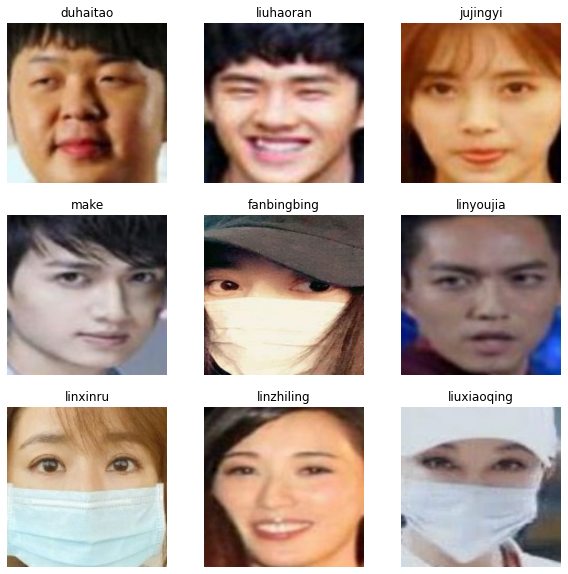

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Test

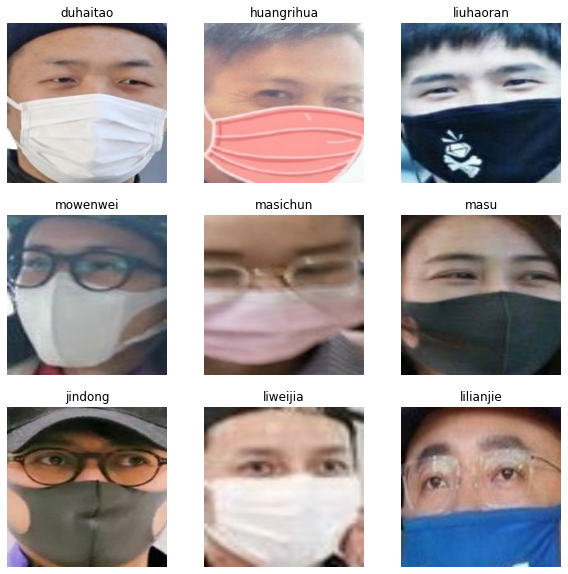

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance
- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

### Augmentation

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

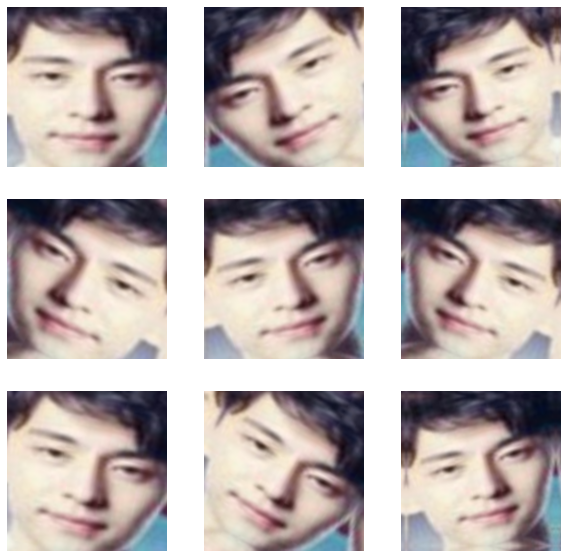

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Our CNN model using Pytorch

### Some imports

In [112]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pathlib
import time
import random
import torchvision.models as models
import torch.nn as nn
!pip install torch pytorch-lightning
!pip install torchviz

In [113]:
# for reading and displaying images
from skimage.io import imread

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.optim as optim
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Subset
import torchvision
from torchviz import make_dot

In [114]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
# torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load data

In [115]:
!find . -name ".DS_Store" -delete

train_transformer=transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        # [0.5,0.5,0.5])
])


train_path='/content/mixed/train'
test_path='/content/mixed/test'

train_loader=DataLoader(
    ImageFolder(train_path,transform=train_transformer),
    batch_size=32, shuffle=True
)

#Classes
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['caizhuoyan', 'chenhe', 'chenqiaoen', 'chenweiting', 'dazhangwei', 'denglun', 'ditianlin', 'dongjie', 'duhaitao', 'fanbingbing', 'fangzuming', 'fengjianyu', 'gaoyixiang', 'gaoyuanyuan', 'guanxiaotong', 'guojingfei', 'hanxue', 'houminghao', 'huangjingyu', 'huangrihua', 'huangtingting', 'huangxiaoming', 'huangzitao', 'huangzongze', 'huge', 'huojianhua', 'huosiyan', 'huozun', 'jianailiang', 'jianghongbo', 'jiangkaitong', 'jiangxin', 'jikejuanyi', 'jinchen', 'jindong', 'jingbairan', 'jingtian', 'jujingyi', 'lidaimo', 'lifeier', 'lilianjie', 'lingengxin', 'linxinru', 'linyoujia', 'linyun', 'linzhiling', 'liruotong', 'liuchutian', 'liuhaoran', 'liushishi', 'liutao', 'liuxiang', 'liuxiaoqing', 'liuyifei', 'liweijia', 'lixiaolu', 'liyifeng', 'liyitong', 'lizi', 'luchen', 'luyi', 'make', 'maozijun', 'masichun', 'masu', 'matianyu', 'mowenwei', 'panyueming', 'pengyuyan']


In [116]:
mean = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(train_loader.dataset)

var = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(train_loader.dataset)*64*64))

In [117]:
VAL_SIZE = 0.2
BATCH_SIZE =32

train = torchvision.datasets.ImageFolder(
    '/content/mixed/train',
    transform=torchvision.transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    # transforms.LinearTransformation(mean_vector=mean),
    transforms.Normalize(mean, 
                        [1,1,1]) #to make the data zero-centric by substracting from the mean and deviding by one
])
    )

# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(train)),
    train.targets,
    stratify=train.targets,
    test_size=VAL_SIZE,
)

# generate subset based on indices
train_split = Subset(train, train_indices)
val_split = Subset(train, val_indices)


test_transformer = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [1, 1, 1])
                                     ])


# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False)


test_loader=DataLoader(
    ImageFolder(test_path,transform=train_transformer),
    batch_size=32, shuffle=False
)

### Bulid the Model

In [118]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=7, stride=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 16, kernel_size=7, stride=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 16, kernel_size=(5, 6), stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            Dropout(0.5),
            Conv2d(16, 16, 5, stride=1),
            BatchNorm2d(16),
            ReLU(inplace=True),

        )

        self.linear_layers = Sequential(
            Linear(6080, len(classes)) 
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x2 = x
        x = self.linear_layers(x)
        return x

In [119]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [120]:
model=Net().to(device)
loss_function=CrossEntropyLoss()
loss_function = loss_function.to(device)

### Plot the model

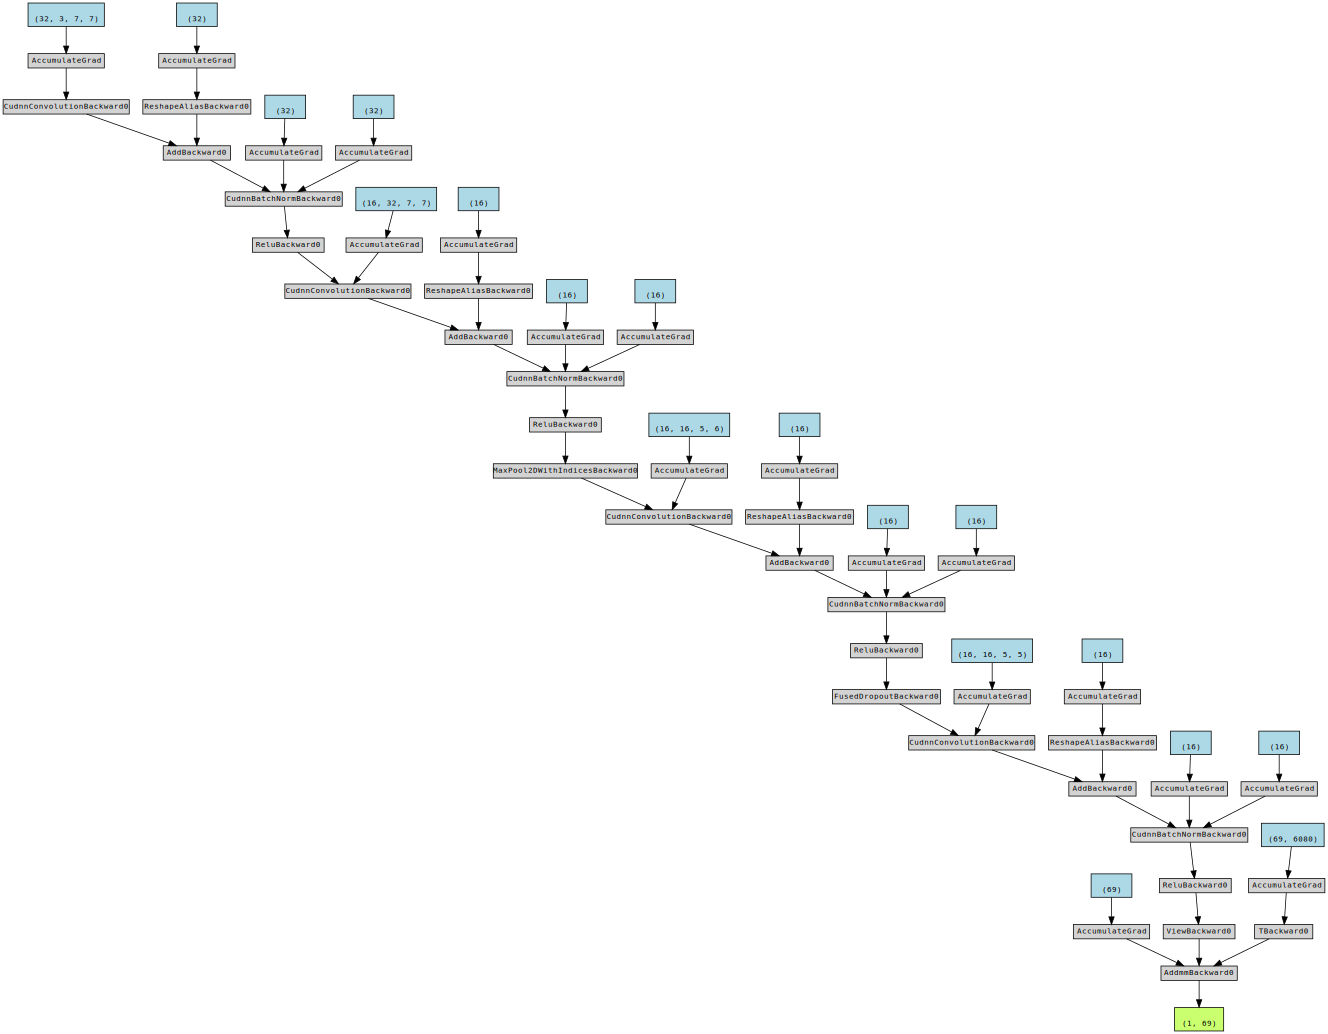

In [123]:
x = torch.zeros(1, 3, 64, 64, dtype=torch.float, requires_grad=False).to(device)
out = model(x)
make_dot(out).render("cnn", format="png")
make_dot(out)

### Train and Evaluate methods

In [101]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, data_iterator, optimizer, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in data_iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = loss_function(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     
    
    return avg_loss, avg_acc



def evaluate(model, data_iterator, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in data_iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_function(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     

    return avg_loss, avg_acc



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




def plot_curves(a, b, label):
    plt.figure(1)
    plt.plot(a, 'b', label="train")
    plt.plot(b, 'g', label="valid")
    plt.title('Training/Valid ' + label)
    plt.legend()
    plt.show()




def main(model, train_iterator, optimizer, loss_function, device, scheduler=None, EPOCHS=3):
  #EPOCHS = 10

  train_loss_all = []
  valid_loss_all = []
  test_loss_all =[]

  train_acc_all = []
  valid_acc_all = []
  test_acc_all = []


  for epoch in range(EPOCHS):
      
      start_time = time.monotonic()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, loss_function , device)
      valid_loss, valid_acc = evaluate(model, val_loader, loss_function, device)
      test_loss, test_acc = evaluate(model, test_loader, loss_function, device)
      if not scheduler is None:
        scheduler.step()

      train_loss_all.append(train_loss)
      valid_loss_all.append(valid_loss)
      test_loss_all.append(test_loss)

      train_acc_all.append(train_acc)
      valid_acc_all.append(valid_acc)
      test_acc_all.append(test_acc)

      
      end_time = time.monotonic()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

  plot_curves(train_loss_all, valid_loss_all, 'loss')
  plot_curves(train_acc_all, valid_acc_all, 'accuracy')

### Training the model

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 4.291 | Train Acc: 1.56%
	 Val. Loss: 4.220 |  Val. Acc: 3.46%
	 Test. Loss: 4.229 |  Test. Acc: 1.04%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 4.192 | Train Acc: 3.91%
	 Val. Loss: 4.200 |  Val. Acc: 1.67%
	 Test. Loss: 4.187 |  Test. Acc: 0.52%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 4.126 | Train Acc: 3.71%
	 Val. Loss: 4.170 |  Val. Acc: 2.46%
	 Test. Loss: 4.217 |  Test. Acc: 5.73%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 4.067 | Train Acc: 4.69%
	 Val. Loss: 4.152 |  Val. Acc: 4.13%
	 Test. Loss: 4.337 |  Test. Acc: 5.21%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 4.032 | Train Acc: 4.88%
	 Val. Loss: 4.138 |  Val. Acc: 5.69%
	 Test. Loss: 4.588 |  Test. Acc: 6.25%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 3.977 | Train Acc: 6.64%
	 Val. Loss: 4.134 |  Val. Acc: 4.13%
	 Test. Loss: 4.823 |  Test. Acc: 1.56%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 3.912 | Train Acc: 8.98%
	 Val. Loss: 4.120 |  Val. Acc: 4.91%
	 Test. Loss: 4.48

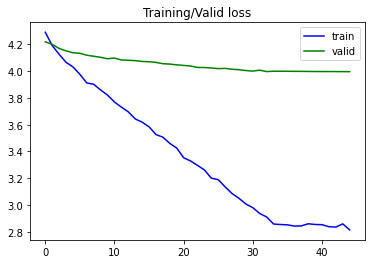

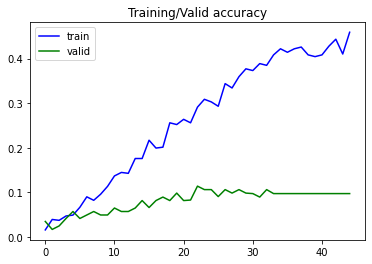

In [66]:
model = model.to(device)
optimizer2 = SGD(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, gamma=0.005, step_size=33)
EPOCHS = 45
main(model, train_loader, optimizer2, loss_function, device, scheduler, EPOCHS)

### Evaluate 

In [67]:
test_loss, test_acc = evaluate(model, test_loader, loss_function, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 6.064 | Test Acc: 2.08%


## Transfer learning 
Using VGG16 with imagenet


### Load model

In [125]:
model_ft = models.vgg16(pretrained=True)
print('Loaded Model')

Loaded Model


In [126]:
ct = 0
ct2 = 0
for child in model_ft.children():

  ct += 1
  if ct == 3:
 
    for param in child.parameters():
      ct2 +=1
      if ct > 1:
        param.requires_grad = False

model_ft.classifier = model_ft.classifier[0:2]
model_ft.classifier[1] = Linear(4096, len(classes))

### Plot the model

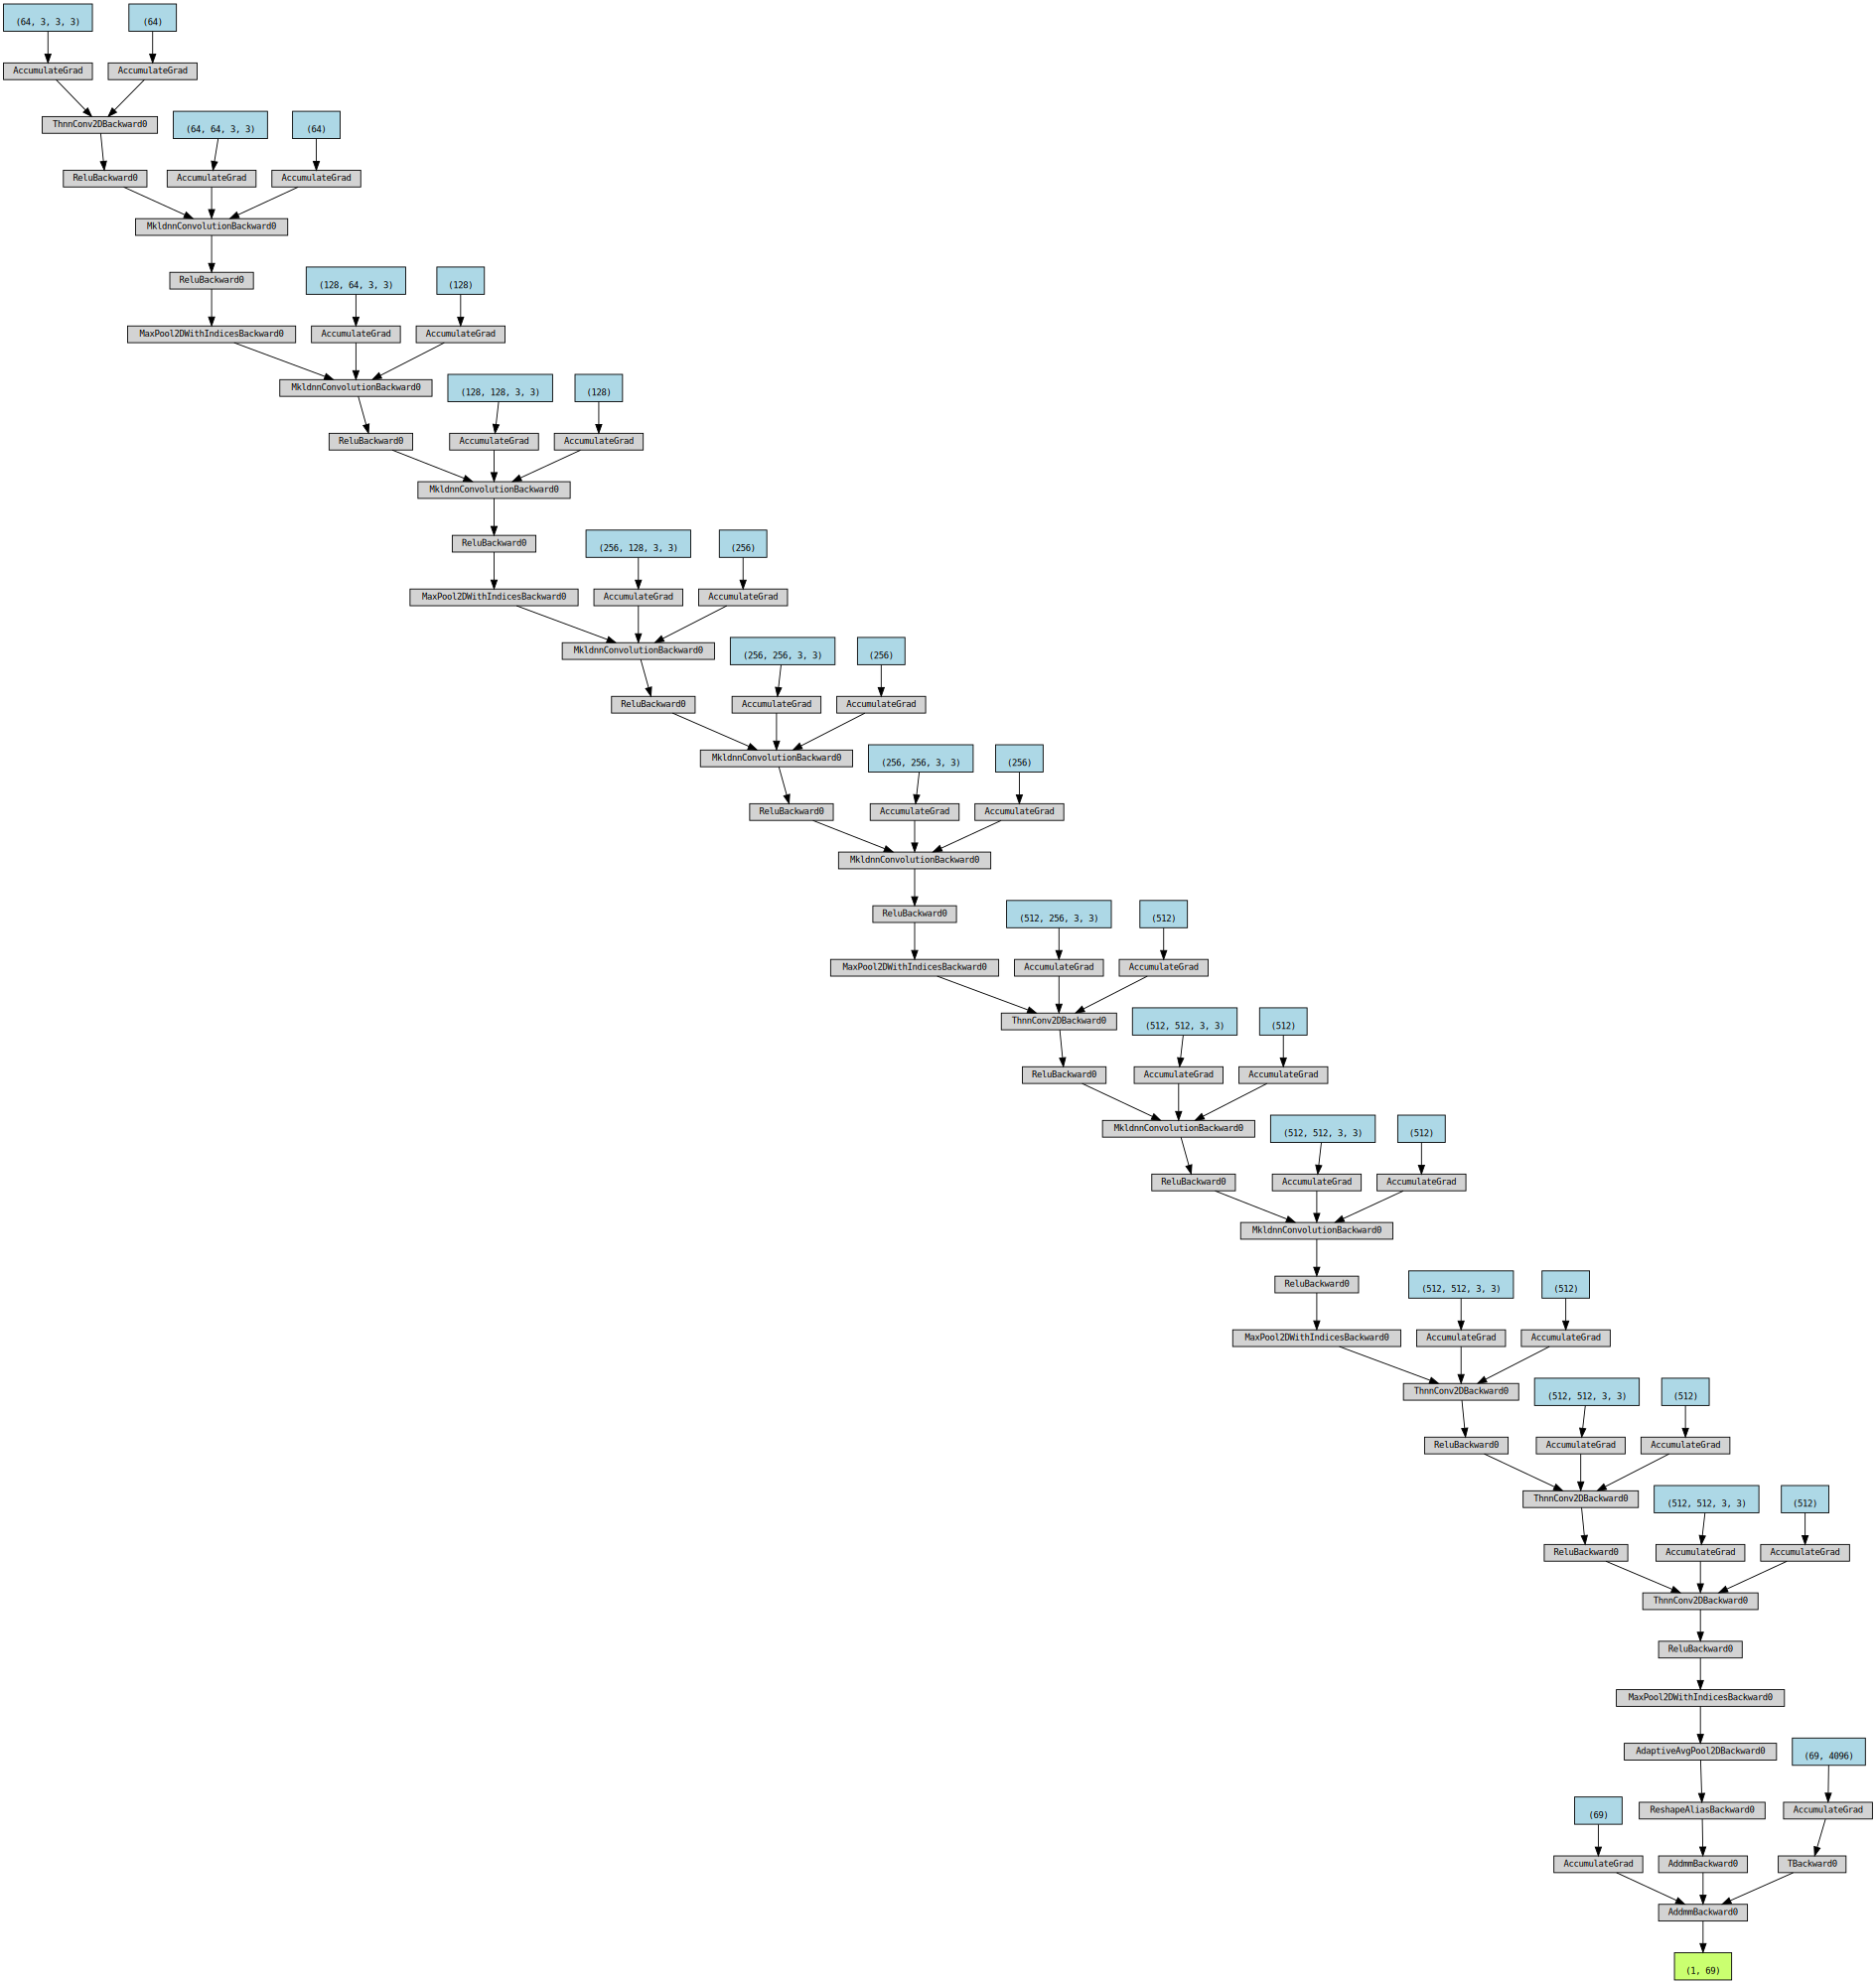

In [127]:
x = torch.zeros(1, 3, 64, 64, dtype=torch.float, requires_grad=False)
out = model_ft(x)
make_dot(out).render("VGG16", format="png")
make_dot(out)  

### Train

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 4.622 | Train Acc: 1.56%
	 Val. Loss: 4.235 |  Val. Acc: 4.13%
	 Test. Loss: 4.186 |  Test. Acc: 2.60%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 4.049 | Train Acc: 5.47%
	 Val. Loss: 4.173 |  Val. Acc: 2.57%
	 Test. Loss: 4.100 |  Test. Acc: 4.69%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 3.814 | Train Acc: 10.35%
	 Val. Loss: 4.156 |  Val. Acc: 2.57%
	 Test. Loss: 4.049 |  Test. Acc: 5.21%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 3.566 | Train Acc: 15.23%
	 Val. Loss: 4.165 |  Val. Acc: 5.92%
	 Test. Loss: 4.035 |  Test. Acc: 7.29%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 3.282 | Train Acc: 20.12%
	 Val. Loss: 4.188 |  Val. Acc: 8.37%
	 Test. Loss: 4.059 |  Test. Acc: 7.29%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 2.963 | Train Acc: 27.54%
	 Val. Loss: 4.245 |  Val. Acc: 9.15%
	 Test. Loss: 4.163 |  Test. Acc: 8.85%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 2.627 | Train Acc: 37.70%
	 Val. Loss: 4.339 |  Val. Acc: 9.93%
	 Test. Loss:

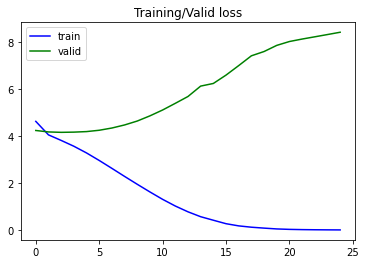

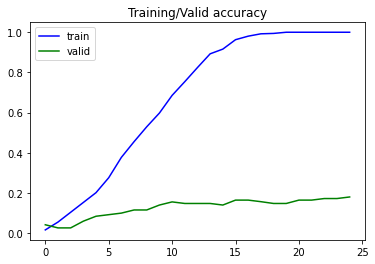

In [105]:
model_ft.to(device)
optimizer=SGD(model_ft.parameters(),lr=0.001, weight_decay=0.0001)
EPOCHS = 25
main(model_ft, train_loader, optimizer, loss_function, device, None, EPOCHS)

### Evaluate

In [106]:
test_loss, test_acc = evaluate(model_ft, test_loader, loss_function, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 9.674 | Test Acc: 13.54%


## CNN-RNN

### Some imports

In [128]:
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Multiply
from keras.layers import GlobalAveragePooling2D, Dense, Reshape, Lambda, LSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import time
import numpy as np

np.random.seed(1337)

### Helpers

In [129]:
class CustomImageDataGenerator(ImageDataGenerator):
    """
    Because Xception utilizes a custom preprocessing method, the only way to utilize this
    preprocessing method using the ImageDataGenerator is to overload the standardize method.
    The standardize method gets applied to each batch before ImageDataGenerator yields that batch.
    """

    def standardize(self, x):
        """
        Taken from keras.applications.xception.preprocess_input
        """
        if self.featurewise_center:
            x /= 255.
            x -= 0.5
            x *= 2.
        return x


def get_training_generator(batch_size=128):
    train_data_dir = '/content/mixed/train'
    validation_data_dir = '/content/mixed/test'
    image_datagen = CustomImageDataGenerator(featurewise_center=True)

    train_generator = image_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size
    )

    val_generator = image_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False
    )

    return train_generator, val_generator


def rgb_to_grayscale(input):
    """Average out each pixel across its 3 RGB layers resulting in a grayscale image"""
    return tf.image.rgb_to_grayscale(input)
    
    
    
    # K.mean(input, axis=3)


def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]

### Load data

In [134]:
batch_size_phase_one = 32
batch_size_phase_two = 16

nb_epochs = 20

img_width = 299
img_height = 299

# Setting tensorbord callback
now = time.strftime("%c")
tensorboard_callback = TensorBoard(log_dir='./logs/' + 'cnn_rnn ' + now, histogram_freq=0, write_graph=True,
                                   write_images=False)

# Loading dataset
print("Loading the dataset with batch size of {}...".format(batch_size_phase_one))
train_generator, val_generator = get_training_generator(batch_size_phase_one)
print("Dataset loaded")

Loading the dataset with batch size of 32...
Found 620 images belonging to 69 classes.
Found 168 images belonging to 69 classes.
Dataset loaded


### Build the model

In [135]:
print("Building model...")
input_tensor = Input(shape=(img_width, img_height, 3))

# Creating CNN
cnn_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = cnn_model.output
cnn_bottleneck = GlobalAveragePooling2D()(x)

# Make CNN layers not trainable
for layer in cnn_model.layers:
    layer.trainable = False

# Creating RNN
x = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
x = Reshape((23, 3887))(x)  # 23 timesteps, input dim of each timestep 3887
x = LSTM(2048, return_sequences=True)(x)
rnn_output = LSTM(2048)(x)

# Merging both cnn bottleneck and rnn's output wise element wise multiplication
x = Multiply()([cnn_bottleneck, rnn_output])
predictions = Dense(69, activation='softmax')(x)

model = Model(input_tensor, predictions)
# print(model.summary())
print("Model built")

Building model...
Model built


### Plot the model

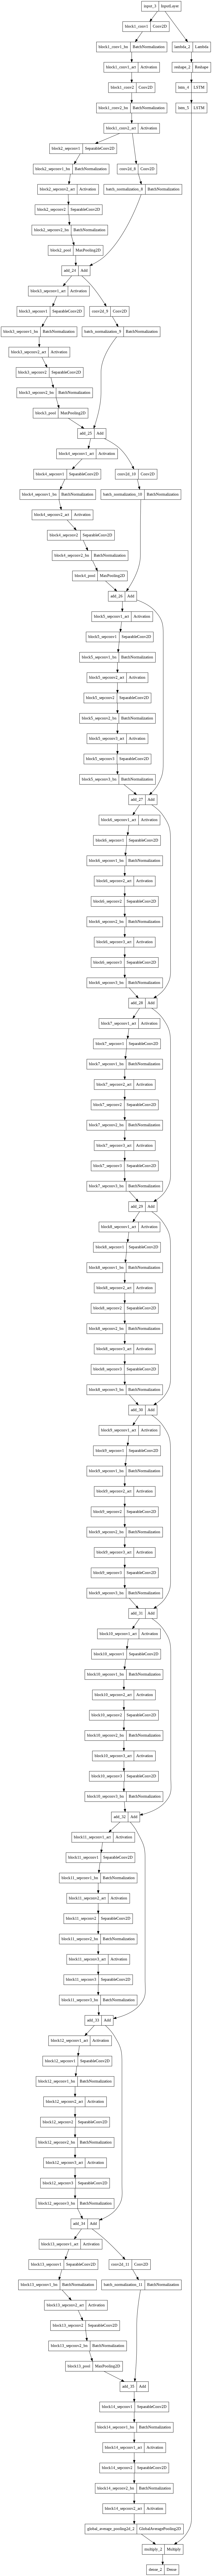

In [136]:
utils.plot_model(model, "cnn-rnn.png")

### Compile and Train...

In [137]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

print("Starting training")
checkpointer = ModelCheckpoint(filepath="./initial_cnn_rnn_weights_2.hdf5", verbose=1, save_best_only=True)
model.fit(train_generator, epochs=nb_epochs, verbose=1,
                    validation_data=val_generator,
                    callbacks=[tensorboard_callback, checkpointer])
print("Initial training done")

Starting training


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 4.1793
Epoch 00001: val_loss improved from inf to 4.04919, saving model to ./initial_cnn_rnn_weights_2.hdf5
20/20 [==============================] - 32s 1s/step - loss: 4.1793 - val_loss: 4.0492
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 3.8865
Epoch 00002: val_loss improved from 4.04919 to 3.94595, saving model to ./initial_cnn_rnn_weights_2.hdf5
20/20 [==============================] - 23s 1s/step - loss: 3.8865 - val_loss: 3.9459
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 3.6755
Epoch 00003: val_loss improved from 3.94595 to 3.85050, saving model to ./initial_cnn_rnn_weights_2.hdf5
20/20 [==============================] - 23s 1s/step - loss: 3.6755 - val_loss: 3.8505
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 3.4995
Epoch 00004: val_loss improved from 3.85050 to 3.77475, saving model to ./initial_cnn_rnn_weights_2.hdf5
20/20 [================

### Finetuning

In [138]:
print("Starting phase two (finetuning)")

# Load two new generator with smaller batch size, needed because using the same batch size
# for the fine tuning will result in GPU running out of memory and tensorflow raising an error
print("Loading the dataset with batch size of {}...".format(batch_size_phase_two))
train_generator, val_generator = get_training_generator(batch_size_phase_two)
print("Dataset loaded")

# Load best weights from initial training
model.load_weights("./initial_cnn_rnn_weights_2.hdf5")

# Make all layers trainable for finetuning
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

checkpointer = ModelCheckpoint(filepath="./finetuned_cnn_rnn_weights_2.hdf5", verbose=1, save_best_only=True
                               )
model.fit(train_generator, epochs=nb_epochs, verbose=1,
                    validation_data=val_generator,
                    callbacks=[tensorboard_callback, checkpointer])

Starting phase two (finetuning)
Loading the dataset with batch size of 16...
Found 620 images belonging to 69 classes.
Found 168 images belonging to 69 classes.
Dataset loaded


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 1.6869 - accuracy: 0.6452 - top_k_categorical_accuracy: 0.8435
Epoch 00001: val_loss improved from inf to 3.36649, saving model to ./finetuned_cnn_rnn_weights_2.hdf5
39/39 [==============================] - 77s 2s/step - loss: 1.6869 - accuracy: 0.6452 - top_k_categorical_accuracy: 0.8435 - val_loss: 3.3665 - val_accuracy: 0.2500 - val_top_k_categorical_accuracy: 0.4524
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.9710 - top_k_categorical_accuracy: 1.0000
Epoch 00002: val_loss improved from 3.36649 to 3.25963, saving model to ./finetuned_cnn_rnn_weights_2.hdf5
39/39 [==============================] - 66s 2s/step - loss: 0.3957 - accuracy: 0.9710 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.2596 - val_accuracy: 0.2500 - val_top_k_categorical_accuracy: 0.5060
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 1.0000 - top_k_categorical_

### Evaluate the model

In [139]:
# Final evaluation of the model
print("Training done, doing final evaluation...")

model.load_weights("./finetuned_cnn_rnn_weights_2.hdf5")

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

scores = model.evaluate(val_generator)
print(model.metrics_names, scores)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Training done, doing final evaluation...
11/11 [==============================] - 7s 362ms/step - loss: 3.2342 - accuracy: 0.2857 - top_k_categorical_accuracy: 0.5536
['loss', 'accuracy', 'top_k_categorical_accuracy'] [3.2341911792755127, 0.2857142984867096, 0.5535714030265808]
accuracy: 28.57%


## Facenet with SVM

### Some imports

In [140]:
import cv2 
from keras.models import load_model
from PIL import Image
import os
!pip install pyyaml h5py 

### Load data and Extract Faces 

In [141]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
# resize pixels to the model size
    image = Image.fromarray(pixels)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [142]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
      if filename[0]==".":
        continue
      path = dir +'/'+ filename
      face = extract_face(path)
      faces.append(face)
    return faces

def load_dataset(dir):
  # list for faces and labels
  X, y = list(), list()
  print("subdir")
  for subdir in os.listdir(dir):
    if subdir[0]==".":
      continue
    path = dir +'/'+ subdir 
    faces = load_face(path)
    labels = [subdir for i in range(len(faces))]
    print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
    X.extend(faces)
    y.extend(labels)
  return np.asarray(X), np.asarray(y)

In [143]:
# load train dataset
trainX, trainy = load_dataset('/content/mixed/train')
print(trainX.shape, trainy.shape)

subdir
loaded 5 sample for class: fangzuming
loaded 10 sample for class: linyoujia
loaded 10 sample for class: lixiaolu
loaded 5 sample for class: lifeier
loaded 5 sample for class: jingbairan
loaded 10 sample for class: jinchen
loaded 15 sample for class: jingtian
loaded 10 sample for class: denglun
loaded 5 sample for class: panyueming
loaded 5 sample for class: liuchutian
loaded 5 sample for class: luyi
loaded 5 sample for class: gaoyuanyuan
loaded 15 sample for class: linxinru
loaded 5 sample for class: dongjie
loaded 5 sample for class: ditianlin
loaded 15 sample for class: huojianhua
loaded 15 sample for class: masichun
loaded 5 sample for class: gaoyixiang
loaded 5 sample for class: liruotong
loaded 10 sample for class: linzhiling
loaded 5 sample for class: luchen
loaded 10 sample for class: huosiyan
loaded 5 sample for class: jiangkaitong
loaded 10 sample for class: liuhaoran
loaded 5 sample for class: fengjianyu
loaded 5 sample for class: linyun
loaded 5 sample for class: huan

In [144]:
# load test dataset
testX, testy = load_dataset('/content/mixed/test')
print(testX.shape, testy.shape)

subdir
loaded 1 sample for class: fangzuming
loaded 3 sample for class: linyoujia
loaded 4 sample for class: lixiaolu
loaded 1 sample for class: lifeier
loaded 1 sample for class: jingbairan
loaded 5 sample for class: jinchen
loaded 7 sample for class: jingtian
loaded 3 sample for class: denglun
loaded 1 sample for class: panyueming
loaded 2 sample for class: liuchutian
loaded 1 sample for class: luyi
loaded 2 sample for class: gaoyuanyuan
loaded 4 sample for class: linxinru
loaded 1 sample for class: dongjie
loaded 2 sample for class: ditianlin
loaded 3 sample for class: huojianhua
loaded 2 sample for class: masichun
loaded 3 sample for class: gaoyixiang
loaded 3 sample for class: liruotong
loaded 1 sample for class: linzhiling
loaded 1 sample for class: luchen
loaded 1 sample for class: huosiyan
loaded 1 sample for class: jiangkaitong
loaded 3 sample for class: liuhaoran
loaded 2 sample for class: fengjianyu
loaded 3 sample for class: linyun
loaded 2 sample for class: huangzitao
load

### Load faceNet 

#### load model

Unfortunately, the code below usually does not work properly.<br/>
You need to download the model manually from this [google drive](https://drive.google.com/drive/folders/12aMYASGCKvDdkygSv1yQq8ns03AStDO_) then upload it to colab.





In [145]:
# !curl "https://drive.google.com/uc?id=1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1&authuser=0&export=download" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0" -H "Accept: */*" -H "Accept-Language: en-US,en;q=0.5" --compressed -H "X-Drive-First-Party: DriveWebUi" -H "X-Json-Requested: true" -H "Content-Type: application/x-www-form-urlencoded;charset=utf-8" -H "Origin: https://drive.google.com" -H "Connection: keep-alive" -H "Referer: https://drive.google.com/drive/folders/12aMYASGCKvDdkygSv1yQq8ns03AStDO_" -H "Cookie: NID=511=fB3Oq2qWMouMb4XeQ4A3ee67RjiMkgHVjA0BPV1aHFHG3eNsfnPy_IXP4dYfpohQf9w86hvhTLK0Ri7dorbp651N2YARquLxjEaPtPGWErm0y7RjAYfDkc7deWy4fl3bFBKJauGVrk_zsmGxesJ7_Wamd_rRMYDpTwoGMoRpR24; ANID=AHWqTUlF6lBZHO1ZEO_7HQWf0dPYUH3Px_ZghN4AEnsf_0Gn36CaWErgdjaVllSn" -H "Sec-Fetch-Dest: empty" -H "Sec-Fetch-Mode: cors" -H "Sec-Fetch-Site: same-origin" -H "TE: trailers" --data-raw "" -o facenet_keras.h5

#### What is faceNet?
The model is a deep convolutional neural network trained via a triplet loss function that encourages vectors for the same identity to become more similar (smaller distance), whereas vectors for different identities are expected to become less similar (larger distance). The focus on training a model to create embeddings directly (rather than extracting them from an intermediate layer of a model) was an important innovation in this work.

In [146]:
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')
utils.plot_model(facenet_model, "facenet_keras.png")

Loaded Model
tcmalloc: large alloc 1177313280 bytes == 0x55fd97090000 @  0x7f8f71422001 0x7f8f6d6b91fa 0x7f8f6d6b92ad 0x7f8f6e8446df 0x7f8f6ed3b261 0x7f8f711b8468 0x7f8f711bad53 0x55fd944e2092 0x7f8f70b6dbf7 0x55fd944e212a



### Get embedding for train and test

In [147]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

In [148]:
emdTrainX = list()
i = 0
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

(620, 128)


In [149]:
emdTestX = list()
i =0
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

(168, 128)


### Setup for classifiction 

In [150]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import pickle
print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
encoder_arr = np.append (trainy, ['Ben_Affleck', 'Ben_Curtis', 'Ben_Howland', 'Benazir_Bhutto', 'Benjamin_Netanyahu', 'Bernard_Landry', 'Bernard_Law', 'Bertie_Ahern'])
out_encoder.fit(encoder_arr)

Dataset: train=620, test=168


LabelEncoder()

In [151]:
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

### Fit the model and the result

In [152]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=85.806, test=50.595


In [153]:
filename = 'linear.sav'
pickle.dump(model, open(filename, 'wb')) 

### Let's look at some **correct** result using test dataset

Expected: jinchen


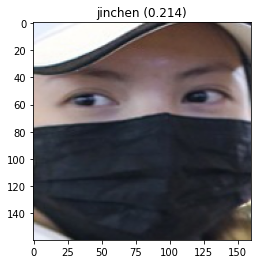

Expected: liuxiaoqing


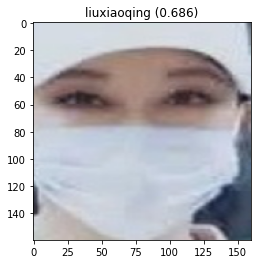

Expected: huangjingyu


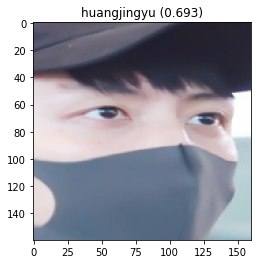

In [154]:
loaded_model = pickle.load(open('linear.sav', 'rb'))
from random import choice
for i in range(10):
    # select a random face from test set
    selection = choice([i for i in range(testX.shape[0])])
    
    random_face = testX[selection]
    random_face_emd = emdTestX_norm[selection]
    random_face_class = testy_enc[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])

    # prediction for the face
    samples = np.expand_dims(random_face_emd, axis=0)
    yhat_class = loaded_model.predict(samples)
    yhat_prob = loaded_model.predict_proba(samples)
    class_index = yhat_class[0]
    if class_index <= 69:
        # get name
        class_probability = yhat_prob[0,class_index] * 100
        predict_names = out_encoder.inverse_transform(yhat_class)
        all_names = out_encoder.inverse_transform([0,1,2,3,4])
        #print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
        if random_face_name[0] == predict_names[0]:
            print('Expected: %s' % random_face_name[0])
            # plot face
            plt.imshow(random_face)
            title = '%s (%.3f)' % (predict_names[0], class_probability)
            plt.title(title)
            plt.show()

### Let's look at some **incorrect** result using test dataset

Expected: liweijia


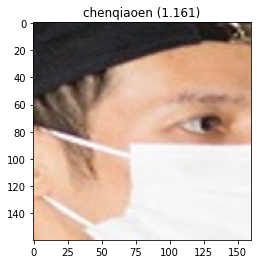

Expected: linyun


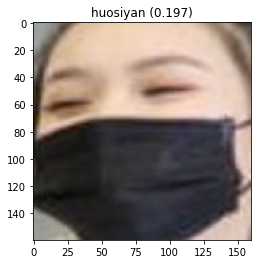

Expected: jingbairan


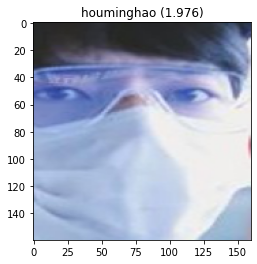

Expected: fanbingbing


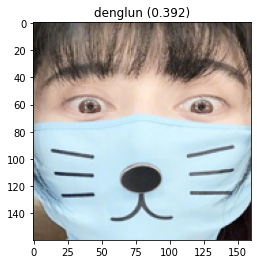

Expected: linyoujia


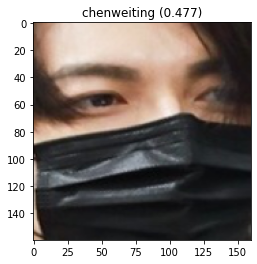

In [155]:
loaded_model = pickle.load(open('linear.sav', 'rb'))
from random import choice
for i in range(10):
    # select a random face from test set
    selection = choice([i for i in range(testX.shape[0])])
    
    random_face = testX[selection]
    random_face_emd = emdTestX_norm[selection]
    random_face_class = testy_enc[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])

    # prediction for the face
    samples = np.expand_dims(random_face_emd, axis=0)
    yhat_class = loaded_model.predict(samples)
    yhat_prob = loaded_model.predict_proba(samples)
    class_index = yhat_class[0]
    if class_index <= 69:
        # get name
        class_probability = yhat_prob[0,class_index] * 100
        predict_names = out_encoder.inverse_transform(yhat_class)
        all_names = out_encoder.inverse_transform([0,1,2,3,4])
        #print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
        if random_face_name[0] != predict_names[0]:
            print('Expected: %s' % random_face_name[0])
            # plot face
            plt.imshow(random_face)
            title = '%s (%.3f)' % (predict_names[0], class_probability)
            plt.title(title)
            plt.show()